# Nested Subsystems

You can also find this example as a single file in the [GitHub repository](https://github.com/milanofthe/pathsim/blob/master/examples/example_nested_subsystems.py).This example demonstrates PathSim's **hierarchical modeling** capabilities using nested subsystems. We'll build a complex Van der Pol oscillator by composing simpler subsystems, showing how to organize large models in a modular way.

## Why Use Subsystems?

Subsystems allow you to:
- **Organize** complex systems into logical modules
- **Reuse** components across different models
- **Abstract** implementation details
- **Scale** to large systems with many components
- **Debug** and test individual modules separately

## The Van der Pol Oscillator Revisited

The stiff Van der Pol oscillator is described by:

$$\frac{dx_1}{dt} = x_2$$
$$\frac{dx_2}{dt} = \mu(1 - x_1^2)x_2 - x_1$$

With $\mu = 1000$ (very stiff!)

## Hierarchical Structure


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Apply PathSim docs matplotlib style for consistent, theme-friendly figures
plt.style.use('../pathsim_docs.mplstyle')

from pathsim import Simulation, Connection, Interface, Subsystem
from pathsim.blocks import Integrator, Scope, Function, Multiplier, Adder, Amplifier, Constant, Pow
from pathsim.solvers import ESDIRK43

## System Parameters

In [9]:
# Initial conditions
x1_0 = 2.0
x2_0 = 0.0

# Van der Pol parameter (high stiffness!)
mu = 1000

# Simulation timestep
dt = 0.01

## Level 1: ODE Function Subsystem

First, we create a subsystem that computes $f(x_1, x_2) = \mu(1 - x_1^2)x_2 - x_1$

This subsystem:
- Takes **two inputs**: $x_1$ and $x_2$
- Returns **one output**: the computed derivative
- Is **self-contained** and reusable


In [16]:
# Interface for the ODE function subsystem
# Input 0: x1
# Input 1: x2  
# Output: μ(1 - x1²)x2 - x1

In = Interface()
M1 = Multiplier()    # For x2 * (1 - x1²)
C1 = Constant(1)     # The constant 1
A1 = Amplifier(mu)   # Multiply by μ
P1 = Adder("+-")     # Sum: μ(1 - x1²)x2 - x1
P2 = Adder("+-")     # Compute: 1 - x1²
S1 = Pow(2)          # Square x1

fn_blocks = [In, M1, C1, A1, P1, P2, S1]

fn_connections = [
    Connection(In[0], S1),         # x1 → x1²
    Connection(In[1], M1[0]),      # x2 → multiplier
    Connection(S1, P2[1]),         # x1² to adder (-)
    Connection(C1, P2[0]),         # 1 to adder
    Connection(P2, M1[1]),         # (1 - x1²) to multiplier
    Connection(M1, A1),            # x2(1 - x1²) → multiply by μ
    Connection(A1, P1[0]),         # μ(...) to final adder
    Connection(In[0], P1[1]),      # x1 to final adder (-)
    Connection(P1, In)             # Result to output
]

# Create the ODE function subsystem
Fn = Subsystem(fn_blocks, fn_connections)

## Level 2: Van der Pol Subsystem

Now we create a subsystem that contains:
- Two **integrators** (for $x_1$ and $x_2$)
- The **ODE function subsystem** we just created


In [19]:
# Interface for VDP subsystem (no inputs, two outputs)
If = Interface()
I1 = Integrator(x1_0)  # Integrator for x1
I2 = Integrator(x2_0)  # Integrator for x2

vdp_blocks = [If, I1, I2, Fn]

vdp_connections = [
    Connection(I2, I1, Fn[1], If[1]),  # x2 → I1, Fn, and output
    Connection(I1, Fn, If),            # x1 → Fn and output[0]
    Connection(Fn, I2)                 # dx2/dt → I2
]

# Create the Van der Pol subsystem
VDP = Subsystem(vdp_blocks, vdp_connections)

## Level 3: Top-Level System

Finally, we create the top-level system that contains:
- The **VDP subsystem**
- A **Scope** for visualization


In [22]:
# Top-level system
Sco = Scope(labels=[r"$x_1(t)$", r"$x_2(t)$"])

blocks = [VDP, Sco]

connections = [
    Connection(VDP, Sco),       # x1 to scope
    # Connection(VDP[1], Sco[1])  # x2 to scope
]

## Simulation Setup


In [25]:
# Initialize simulation
Sim = Simulation(
    blocks, 
    connections, 
    dt=dt, 
    log=True, 
    Solver=ESDIRK43, 
    tolerance_lte_abs=1e-6, 
    tolerance_lte_rel=1e-4,
    tolerance_fpi=1e-7
)

# Run simulation (note: 2*mu for long-term dynamics)
Sim.run(2*mu)

2025-10-10 11:38:59,878 - INFO - LOGGING (log: True)
2025-10-10 11:38:59,879 - INFO - BLOCK (type: Subsystem, dynamic: True, events: 0)
2025-10-10 11:38:59,880 - INFO - BLOCK (type: Scope, dynamic: False, events: 0)
2025-10-10 11:38:59,880 - INFO - GRAPH (size: 2, alg. depth: 1, loop depth: 0, runtime: 0.043ms)
2025-10-10 11:38:59,881 - INFO - STARTING -> TRANSIENT (Duration: 2000.00s)
2025-10-10 11:38:59,881 - INFO - TRANSIENT:   0% | elapsed: 00:00:00 (eta: --:--:--) | 0 steps (N/A steps/s)
2025-10-10 11:39:00,193 - INFO - TRANSIENT:  27% | elapsed: 00:00:00 (eta: 00:00:00) | 44 steps (141.1 steps/s)
2025-10-10 11:39:00,435 - INFO - TRANSIENT:  40% | elapsed: 00:00:00 (eta: 00:00:00) | 58 steps (57.8 steps/s)
2025-10-10 11:39:01,233 - INFO - TRANSIENT:  68% | elapsed: 00:00:01 (eta: 00:00:00) | 204 steps (182.9 steps/s)
2025-10-10 11:39:01,465 - INFO - TRANSIENT:  80% | elapsed: 00:00:01 (eta: 00:00:00) | 216 steps (51.8 steps/s)
2025-10-10 11:39:02,303 - INFO - TRANSIENT: 100% | ela

{'total_steps': 362, 'successful_steps': 252, 'runtime_ms': 2422.6369000025443}

## Results: Time Series

The Van der Pol oscillator with $\mu = 1000$ exhibits **relaxation oscillations** - fast transitions between slow phases. This requires a stiff solver to handle efficiently.

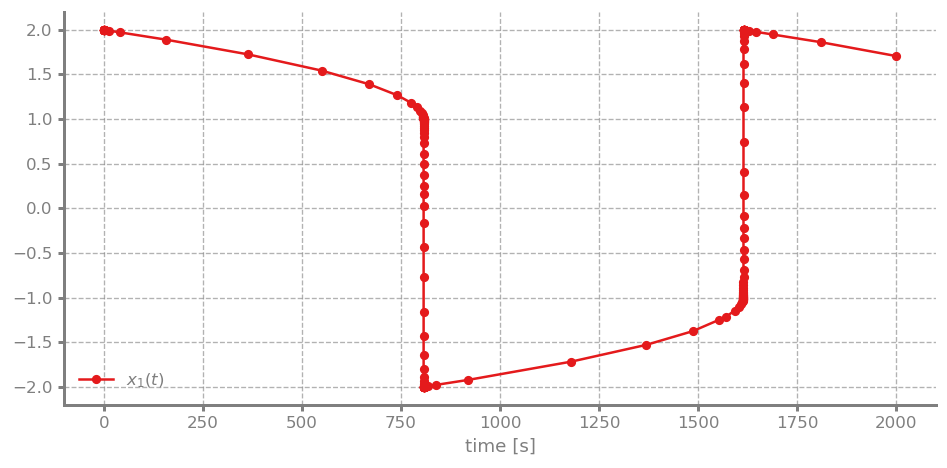

In [28]:
Sco.plot(".-", lw=1.5)
plt.show()

## Subsystem Benefits Demonstrated

This example shows several advantages of subsystems:

1. **Modularity**: The ODE function is completely separate from the integration
2. **Reusability**: The `Fn` subsystem could be used in other models
3. **Clarity**: The top level is clean - just VDP and Scope
4. **Debugging**: Each subsystem can be tested independently
5. **Abstraction**: Inner complexity is hidden from higher levels

## Comparison with ODE Block

Compare this hierarchical approach with using a single `ODE` block:

```python
# Alternative: Using ODE block (simpler but less modular)
def vdp_ode(x, u, t):
    return np.array([x[1], mu*(1 - x[0]**2)*x[1] - x[0]])

VDP = ODE(vdp_ode, np.array([x1_0, x2_0]))
```

Both approaches work! Use subsystems when:
- You need modularity and reusability
- The system is complex with many components
- You want to visualize internal signals
- You're building block diagram models